let's load our data
PS: if the folowing line fails to execute you probably need to run "Feature engineering and exploration" notebook first

In [40]:
%store -r train_X
%store -r train_y
%store -r test
%store -r df_test

In [41]:
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import numpy as np
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
%matplotlib inline

create a validation and train set

In [42]:
all_train_X, all_train_y = train_X, train_y
train_X, val_X, train_y, val_y = train_test_split(train_X, train_y, random_state=42, test_size=0.25)

run xgboost regressor with enabling early stop to try to prevent overfitting and discovering a suitable number of estimators

/home/ghassen/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


487


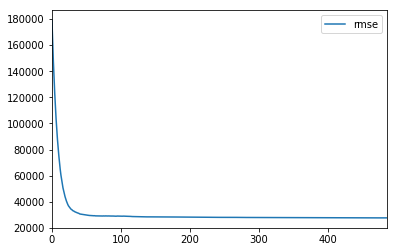

In [43]:
xg_model = XGBRegressor(n_estimators=10000, objective ='reg:linear' , learning_rate=0.1,max_depth=3)
xg_model.fit(train_X, train_y, early_stopping_rounds=50,
             eval_set=[(val_X, val_y)], verbose=False)
max_estimators = len(xg_model.evals_result()['validation_0']['rmse'])
print(max_estimators)
pd.DataFrame(xg_model.evals_result()['validation_0']['rmse'], columns=['rmse']).plot()

In [44]:
predictions = xg_model.predict(val_X)
predictions_train = xg_model.predict(train_X)
print("Root Mean Squarred Error Train: " + str(np.sqrt( mean_squared_error(predictions_train, train_y))))
print("Root Mean Squarred Error Valid: " + str(np.sqrt( mean_squared_error(predictions, val_y))))

Root Mean Squarred Error Train: 7056.047507783549
Root Mean Squarred Error Valid: 27619.051606964138


after playing arround with parameters and observing their effect on the validationg set. We should move on and train our model on the hole dataset

In [45]:
xg_model = XGBRegressor(n_estimators=500, objective ='reg:linear' , learning_rate=0.1,max_depth=2)

xg_model.fit(all_train_X, all_train_y, verbose=False)

/home/ghassen/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/ghassen/anaconda3/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=2,
       min_child_weight=1, missing=None, n_estimators=500, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

generate our submission file

In [46]:
preds = xg_model.predict(test)
output=pd.DataFrame({'Id':df_test['Id'], 'SalePrice':preds})
output.to_csv('submission.csv', index=False)

Xgboost have a neat property wich allows us to gain some insights on the importance of features.
We should store these features since it might be usefull for feature selection when working on different models

In [47]:
features_scores = pd.DataFrame({"feat" : all_train_X.columns, 'score' : xg_model.feature_importances_}) 
features_scores.sort_values(by=["score"], inplace =True , ascending=False) 
%store features_scores

Stored 'features_scores' (DataFrame)


We do also export model's prediction to be used later with stacking and training a meta model

In [48]:
xgboost_predictions_train = xg_model.predict(all_train_X)
xgboost_predictions_test = xg_model.predict(test)
%store xgboost_predictions_train
%store xgboost_predictions_test

Stored 'xgboost_predictions_train' (ndarray)
Stored 'xgboost_predictions_test' (ndarray)
